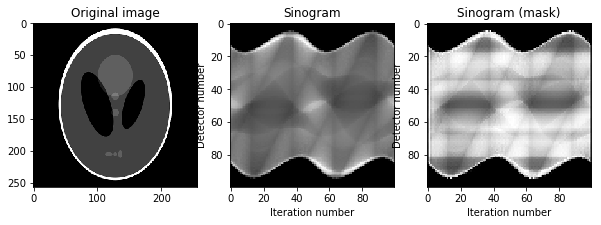

In [7]:
from skimage import data, io, filters, exposure, measure, color, feature
import matplotlib.pyplot as plt
import numpy as np


def addPadding(img):
    result = np.zeros([max(img.shape), max(img.shape)]) if max(img.shape) % 2 == 1 else np.zeros(
        [max(img.shape) + 1, max(img.shape) + 1])
    result[:img.shape[0], :img.shape[1]] = img
    return result


def bresenhamGenerator(x0, y0, x1, y1):
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2*dy - dx
    y = 0

    for x in range(dx + 1):
        yield [x0 + x*xx + y*yx, y0 + x*xy + y*yy]
        if D >= 0:
            y += 1
            D -= 2*dx
        D += 2*dy


def isValidPoint(x, y):
    if x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[0]:
        return True
    else:
        return False


def normalize(vector):
    return [x / max(vector) if max(vector) != 0 and x >= 0 else 0 for x in vector]


def unsharpMasking(vector):
    for i in range(len(vector)):
        if i != 0 and i != len(vector) - 1:
            vector[i - 1] -= vector[i] * 0.3
            vector[i + 1] -= vector[i] * 0.3
            vector[i] += 1.2 * vector[i]
    return normalize(vector)


def getValues(emitter, detectors):
    values = []
    for det in detectors:
        value = 0
        processedPixels = 0
        for i in bresenhamGenerator(emitter[0], emitter[1], det[0], det[1]):
            if isValidPoint(i[0], i[1]):
                value += img[i[0], i[1]]
                processedPixels += 1
                if debug:
                    markedImg[i[0], i[1]] = 1
        if processedPixels != 0:
            values.append(np.float64(value / processedPixels))
        else:
            values.append(np.float64(0))
    return values


def getPositions(angDeg, detectors, detectorsAngle):
    ang = np.deg2rad(angDeg)
    positions = []
    r = img.shape[0] * np.sqrt(2) / 2
    center = int(img.shape[0] / 2)
    positions.append([int(r * np.cos(ang)) + center,
                      int(r * np.sin(ang)) + center])
    if detectors > 1:
        for i in range(detectors):
            position = [int(r * np.cos(ang + np.pi - detectorsAngle / 2 + i * detectorsAngle / (detectors - 1))) + center,
                        int(r * np.sin(ang + np.pi - detectorsAngle / 2 + i * detectorsAngle / (detectors - 1))) + center]
            positions.append(position)
    return positions


def getSinogram(detectors, detectorsAngle, iterations):
    sinogram = []
    angles = np.linspace(0., 360., iterations, endpoint=False)
    for ang in angles:
        positions = getPositions(ang, detectors, detectorsAngle)

        values = getValues(positions[0], positions[1:])
        sinogram.append(values)
    return sinogram


def drawSinogram(detectors, detectorsAngle, iterations):
    detectorsAngle = 2 * np.deg2rad(detectorsAngle)

    if debug:
        markedImg = img.copy()

    sinogram = getSinogram(detectors, detectorsAngle, iterations)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

    if debug:
        ax1.set_title("Image - scanned pixel marked")
        ax1.imshow(markedImg, cmap=plt.cm.Greys_r)
    else:
        ax1.set_title("Original image")
        ax1.imshow(img, cmap=plt.cm.Greys_r)

    sinogram = np.array(sinogram).transpose()

    if debug:
        print('Img:\n', img)
        print('Sinogram:\n', sinogram)
        print('Sinogram dimensions: ', len(sinogram), ', ', len(sinogram[0]))

    ax2.set_title("Sinogram")
    ax2.set_xlabel("Iteration number")
    ax2.set_ylabel("Detector number")
    ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

    ax3.set_title("Sinogram (mask)")
    ax3.set_xlabel("Iteration number")
    ax3.set_ylabel("Detector number")
    ax3.imshow([unsharpMasking(vector)
                for vector in sinogram], cmap=plt.cm.Greys_r)
    plt.show()


# Różne przykładowe zdjęcia do testowania
# img = addPadding(data.imread("mozg_inverted_400.png", as_gray=True))
img = addPadding(data.imread("slp256.png", as_gray=True))
# img = addPadding(np.zeros([512, 512], dtype=np.uint8))
# img = addPadding(np.zeros([40, 40], dtype=np.uint8))
# img[0, 20] = 1
# img[10,25] = img[11,27] = img[12, 29] = 0.5
# img[10,26] = img[11,26] = img[12, 27] = 0.25

# n - ilość detektorów
detectors = 100
# l (deg) - kąt między skrajnymi detektorami przy emiterze
detectorsAngle = 90
# Ilość pomiarów
iterations = 100
# Zaznaczanie odwiedzonych, printy itd.
debug = False

drawSinogram(detectors, detectorsAngle, iterations)


In [9]:
from ipywidgets import *
img = addPadding(data.imread("slp256.png", as_gray=True))
interact(drawSinogram, detectors=(10, 180, 1), detectorsAngle=(5, 90, 1), iterations=(1, 200, 1))

interactive(children=(IntSlider(value=95, description='detectors', max=180, min=10), IntSlider(value=47, descr…

<function __main__.drawSinogram(detectors, detectorsAngle, iterations)>